In [4]:
#Librerie utili
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats 
import scipy.stats as st

In [5]:
con = sqlite3.connect("../code/omnet/simulations/results/simulate.sca")

In [6]:
dfThroughput=pd.read_sql_query("""
select scenario, config, clients, CAST(attrValue as INT), statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients,  CAST(attrValue as INT)
""", con)

In [8]:
scenarios = ["s1","s2","s3","s4"]

In [9]:
dfThroughput['throughput_mean'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform('mean')
dfThroughput['throughput_residual'] = dfThroughput['throughput'] - dfThroughput['throughput_mean']


## Test

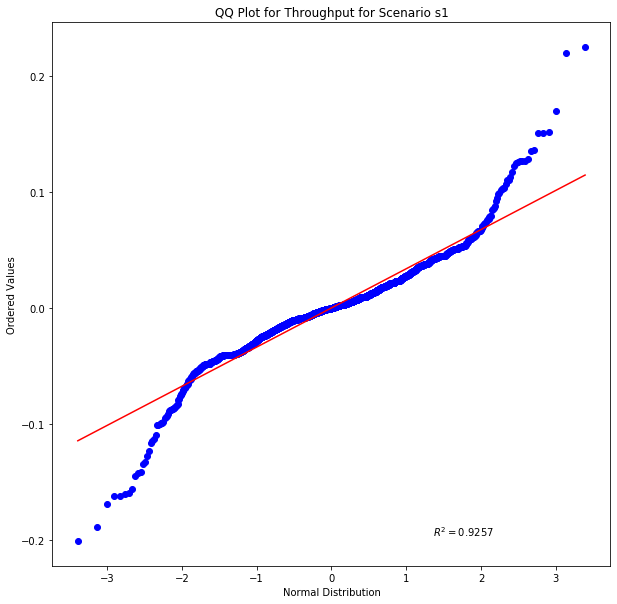

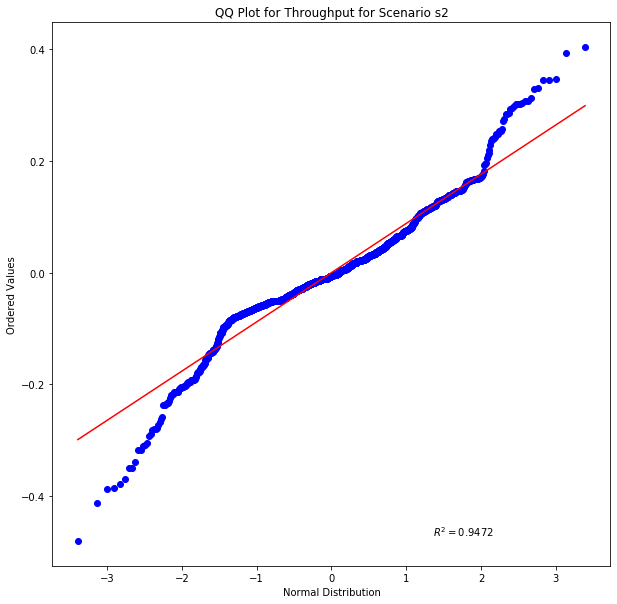

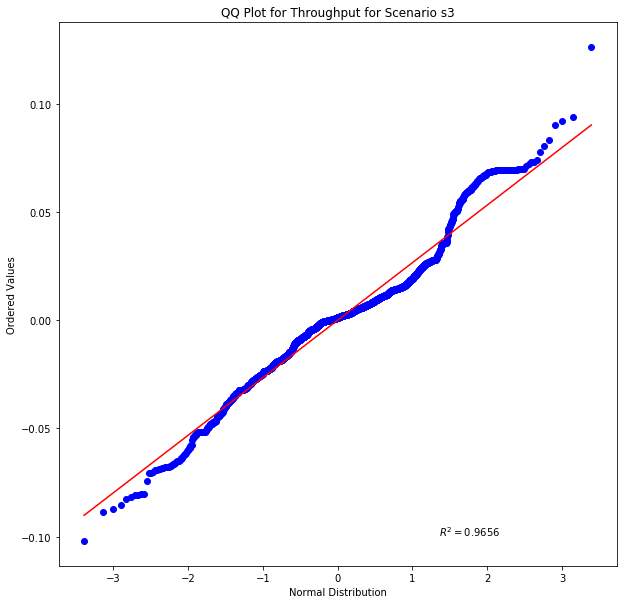

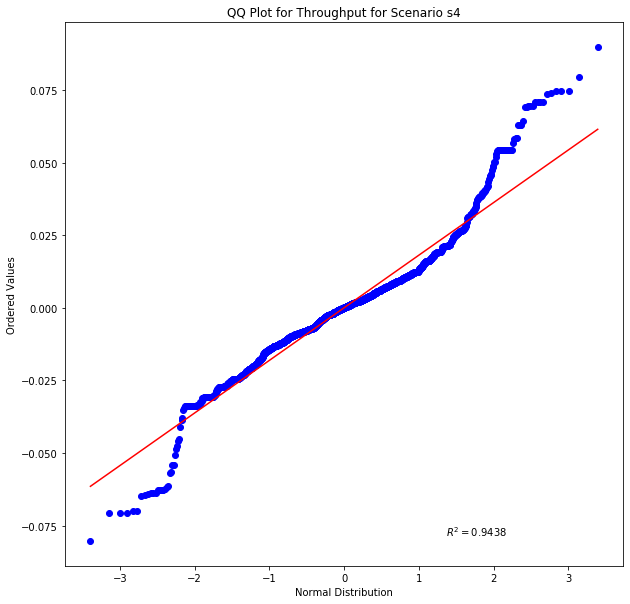

In [10]:
#Normality Test

for scenario in scenarios:
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))

    repThroughput=dfThroughput.loc[(dfThroughput['scenario']==scenario)]['throughput_residual']
    qqPlot = stats.probplot(list(repThroughput), dist='norm',plot=plt,rvalue=True)
    plt.title("QQ Plot for Throughput for Scenario "+scenario)
    plt.xlabel("Normal Distribution")


Normality assumption hold

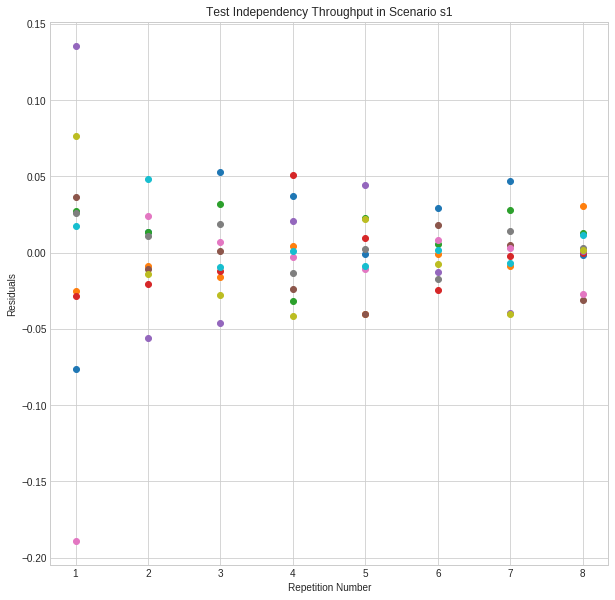

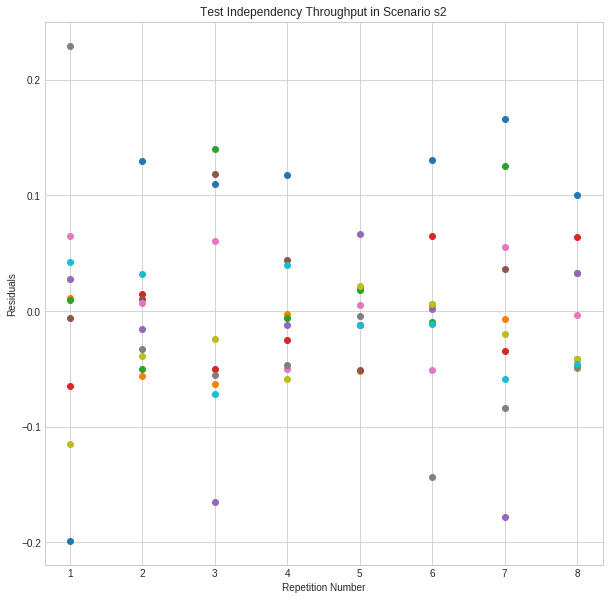

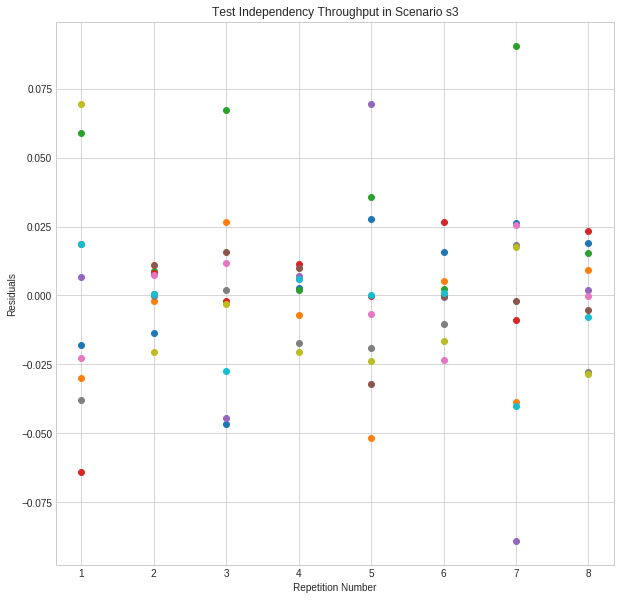

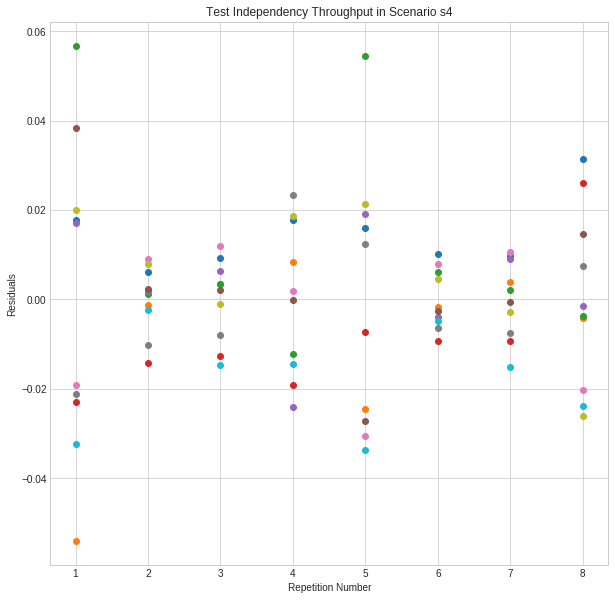

In [11]:
#Independency


for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
        #print(dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist())
        sublist = dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=[*range(1,len(y)+1,1)]
    plt.plot(x, y, 'o')


    plt.title("Test Independency Throughput in "+"Scenario "+scenario)
    plt.xlabel("Repetition Number")
    plt.ylabel("Residuals")


Independency assumption hold, no visible trend

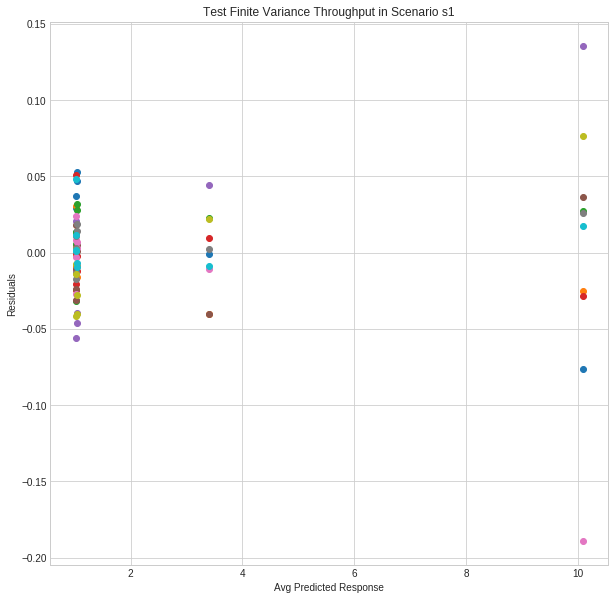

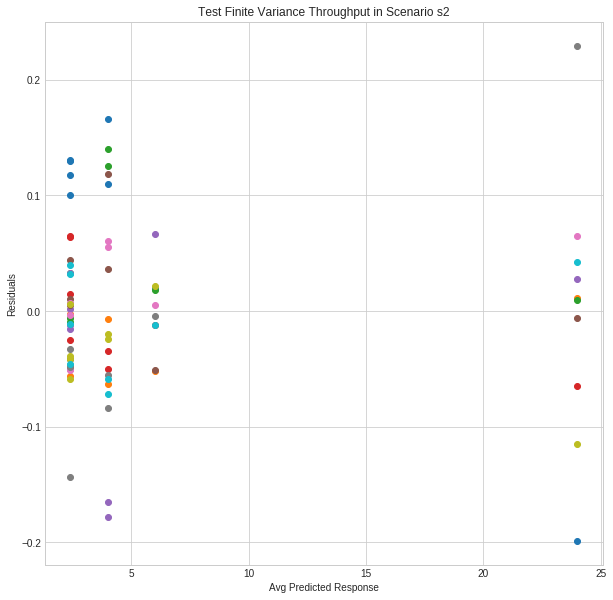

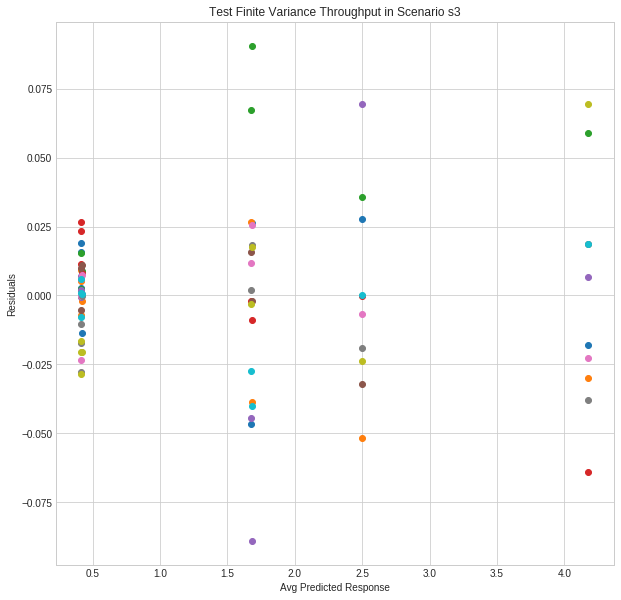

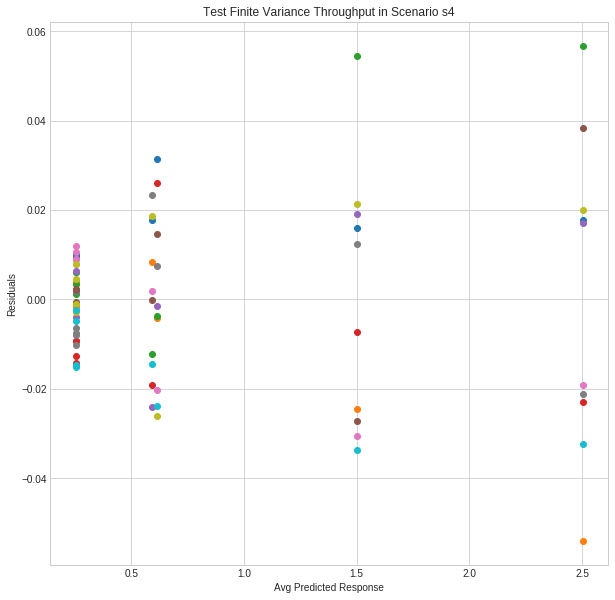

In [12]:
#Finite Variance
for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
        #print(dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist())
        sublist = dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist()
        y.append(sublist)
    
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))

    x=dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_mean"].values.tolist()
    plt.plot(x, y, 'o')


    plt.title("Test Finite Variance Throughput in "+"Scenario "+scenario)
    plt.xlabel("Avg Predicted Response")
    plt.ylabel("Residuals")


Slightly increasing trend, but residuals are two order of magnitude smaller then avg predicted response, so the hypothesys holds